## Import Libraries 

In [83]:
%matplotlib inline
import collections
from sklearn import preprocessing
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

## Define Functions

In [84]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Import Dataset 

In [85]:
path = "./data/"
preprocess = True

filename_read = os.path.join(path,"UNSW_NB15_training-set_csc215.csv")
dataset = pd.read_csv(filename_read,na_values=['NA','?'])   #Removing missing values
print('DataSet Shape: ', dataset.shape)

filename_read = os.path.join(path,"UNSW_NB15_test-set_csc215.csv")
datatest = pd.read_csv(filename_read,na_values=['NA','?'])  #Removing missing values
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (175341, 45)
DataTest Shape:  (82332, 45)


## Checking for duplicates 

In [86]:
#Removing Duplicates
dataset = dataset.drop_duplicates()
datatest = datatest.drop_duplicates()

print('DataSet Shape: ', dataset.shape)
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (175341, 45)
DataTest Shape:  (82332, 45)


## Removing special characters and

In [87]:
ind=dataset[dataset['service']=='-'].index
dataset.drop(ind, inplace=True)

ind=datatest[datatest['service']=='-'].index
datatest.drop(ind, inplace=True)

print('DataSet Shape: ', dataset.shape)
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (81173, 45)
DataTest Shape:  (35179, 45)


## Data Balancing

In [88]:
#Data_Balncing
dataset_normal_count=len(dataset[dataset['label'] == 1])
dataset_attack_count=len(dataset[dataset['label'] == 0])

dataset_normal=(dataset[dataset['label'] == 1])
dataset_attack=(dataset[dataset['label'] == 0])

if (dataset_normal_count>dataset_attack_count):
    frames=[dataset_normal.head(dataset_attack_count),dataset_attack.head(dataset_attack_count) ]
    dataset= pd.concat(frames)  
else:
    frames=[dataset_normal.head(dataset_normal_count),dataset_attack.head(dataset_normal_count) ]
    dataset= pd.concat(frames)

print('DataSet Shape: ', dataset.shape)
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (38976, 45)
DataTest Shape:  (35179, 45)


## Filtering Data by Dropping columns


In [89]:
dataset.drop(['rate','ct_src_ltm','ct_dst_ltm','trans_depth','dur','swin','dwin','sjit','djit','id'],axis=1,inplace=True)
datatest.drop(['rate','ct_src_ltm','ct_dst_ltm','trans_depth','dur','swin','dwin','sjit','djit','id'],axis=1,inplace=True)

print('No of Columns of DataSet: ', len(dataset.columns))
print('No of Columns of DataTest: ', len(datatest.columns))

No of Columns of DataSet:  35
No of Columns of DataTest:  35


##  Encoding Categorical and Numeric Values

In [90]:
encode_text_dummy(dataset, 'ct_state_ttl')
        
encode_text_dummy(dataset, 'ct_src_dport_ltm')
encode_text_dummy(dataset, 'ct_dst_sport_ltm')
    
encode_text_index(dataset,'proto')
encode_text_index(dataset,'service') 
encode_text_index(dataset,'state')
encode_text_index(dataset,'attack_cat')

remove_outliers(dataset, "ct_srv_src",dataset["ct_srv_src"].std())

#remove_outliers(dataset, "sjit",dataset["sjit"].std())
#remove_outliers(dataset, "djit",dataset["djit"].std())

#encode_numeric_range(dataset,'sjit',normalized_low=0,normalized_high=1,data_low=None, data_high=None)
#encode_numeric_range(dataset,'djit',normalized_low=0,normalized_high=1,data_low=None, data_high=None)

#encode_numeric_zscore(dataset, 'sjit', mean=None, sd=None)
#encode_numeric_zscore(dataset, 'djit', mean=None, sd=None)

#encode_numeric_zscore(dataset, 'ct_src_ltm', mean=None, sd=None)
#encode_numeric_zscore(dataset, 'ct_dst_ltm', mean=None, sd=None)

#dataset['tcprtt'] = dataset['tcprtt'].mean()
#dataset['synack'] = dataset['synack'].mean()
#dataset['ackdat'] = dataset['ackdat'].mean()
    
encode_numeric_zscore(dataset, 'sinpkt', mean=None, sd=None)
encode_numeric_zscore(dataset, 'dinpkt', mean=None, sd=None)

#encode_numeric_zscore(dataset, 'response_body_len', mean=None, sd=None)

#remove_outliers(dataset, "response_body_len",dataset["response_body_len"].std())

#encode_numeric_zscore(dataset, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(dataset, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(dataset, 'dttl', mean=None, sd=None)
#encode_numeric_zscore(dataset, 'sttl', mean=None, sd=None)

encode_numeric_zscore(dataset, 'sload', mean=None, sd=None)
encode_numeric_zscore(dataset, 'dload', mean=None, sd=None)
encode_numeric_zscore(dataset, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(dataset, 'stcpb', mean=None, sd=None)
encode_numeric_zscore(dataset, 'spkts', mean=None, sd=None)
encode_numeric_zscore(dataset, 'dpkts', mean=None, sd=None)

##############################################################################################################################

encode_text_dummy(datatest, 'ct_state_ttl')

encode_text_dummy(datatest, 'ct_src_dport_ltm')
encode_text_dummy(datatest, 'ct_dst_sport_ltm')

encode_text_index(datatest,'proto')
encode_text_index(datatest,'service')
encode_text_index(datatest,'state')
encode_text_index(datatest,'attack_cat')

remove_outliers(datatest, "ct_srv_src", datatest["ct_srv_src"].std())

encode_numeric_zscore(datatest, 'sinpkt', mean=None, sd=None)
encode_numeric_zscore(datatest, 'dinpkt', mean=None, sd=None)

encode_numeric_zscore(datatest, 'sload', mean=None, sd=None)
encode_numeric_zscore(datatest, 'dload', mean=None, sd=None)

encode_numeric_zscore(datatest, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(datatest, 'stcpb', mean=None, sd=None)
encode_numeric_zscore(datatest, 'spkts', mean=None, sd=None)
encode_numeric_zscore(datatest, 'dpkts', mean=None, sd=None)

print('DataSet Shape: ', dataset.shape)
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (38817, 93)
DataTest Shape:  (35179, 121)


## Intersection of Dummy Columns

In [91]:
yLabel=datatest['label']

datatest=datatest[dataset.columns.intersection(datatest.columns)]#feeding only intersecting column's data for testing
dataset=dataset[dataset.columns.intersection(datatest.columns)]#feeding only intersecting column's data for training

print('DataSet Shape: ', dataset.shape)
print('DataTest Shape: ', datatest.shape)

DataSet Shape:  (38817, 93)
DataTest Shape:  (35179, 93)


# Neural Network

## 1) Activation - Relu and Optimizer - Adam

0
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 47.65396, saving model to ./best_weights.hdf5
38817/38817 - 8s - loss: 100.7701 - val_loss: 47.6540
Epoch 2/100

Epoch 00002: val_loss improved from 47.65396 to 28.45895, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 44.4850 - val_loss: 28.4590
Epoch 3/100

Epoch 00003: val_loss improved from 28.45895 to 21.22513, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 35.3237 - val_loss: 21.2251
Epoch 4/100

Epoch 00004: val_loss did not improve from 21.22513
38817/38817 - 5s - loss: 27.0884 - val_loss: 42.2314
Epoch 5/100

Epoch 00005: val_loss improved from 21.22513 to 1.71852, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 21.9039 - val_loss: 1.7185
Epoch 6/100

Epoch 00006: val_loss did not improve from 1.71852
38817/38817 - 5s - loss: 14.6964 - val_loss: 2.2065
Epoch 7/100

Epoch 00007: val_loss did not improve from 1.71852
38817/38817 - 5s

Epoch 9/100

Epoch 00009: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 3.2579 - val_loss: 0.9708
Epoch 10/100

Epoch 00010: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 1.0240 - val_loss: 1.0816
Epoch 11/100

Epoch 00011: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.9117 - val_loss: 0.4814
Epoch 12/100

Epoch 00012: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.5114 - val_loss: 0.2794
Epoch 13/100

Epoch 00013: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.3620 - val_loss: 0.3095
Epoch 14/100

Epoch 00014: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.2386 - val_loss: 0.3289
Epoch 15/100

Epoch 00015: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.3476 - val_loss: 0.2165
Epoch 16/100

Epoch 00016: val_loss did not improve from 0.05649
38817/38817 - 5s - loss: 0.1788 - val_loss: 0.1471
Epoch 17/100

Epoch 00017: val_loss did not improve from 0.05649
38817/38

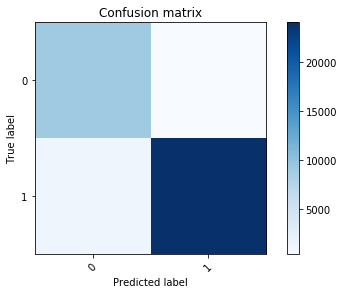

Plotting ROC Curve


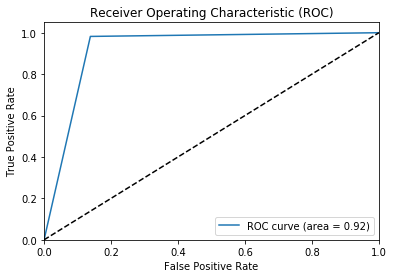

In [45]:
#Create Path and Make Directory
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(64, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
#print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

##  Activation - Relu and Optimizer - SGD

0
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
38817/38817 - 7s - loss: nan - val_loss: nan


C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1234: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:991: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100

Epoch 00002: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 00004: val_loss did not improve from inf
38817/38817 - 5s - loss: nan - val_loss: nan
Epoch 5/100

Epoch 00005: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 00005: early stopping
1
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
38817/38817 - 7s - loss: nan - val_loss: nan


C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1234: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:991: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100

Epoch 00002: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 00004: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 5/100

Epoch 00005: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 00005: early stopping
2
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
38817/38817 - 7s - loss: nan - val_loss: nan


C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1234: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:991: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100

Epoch 00002: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 00004: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 5/100

Epoch 00005: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 00005: early stopping
3
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss did not improve from inf
38817/38817 - 7s - loss: nan - val_loss: nan


C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:1234: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\callbacks.py:991: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


Epoch 2/100

Epoch 00002: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 3/100

Epoch 00003: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 4/100

Epoch 00004: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 5/100

Epoch 00005: val_loss did not improve from inf
38817/38817 - 6s - loss: nan - val_loss: nan
Epoch 00005: early stopping
Training finished...Loading the best model

[0 0 0 ... 0 0 0]
Accuracy score: 0.27360072770687055
Precision score: 0.07485735820172913
Recall score: 0.27360072770687055
F1 score: 0.11755231694396165
              precision    recall  f1-score   support

           0       0.27      1.00      0.43      9625
           1       0.00      0.00      0.00     25554

    accuracy                           0.27     35179
   macro avg       0.14      0.50      0.21     35179
weighted avg       0.07      0.27      0.12     35179

[[ 9625     0]
 [25554    

C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


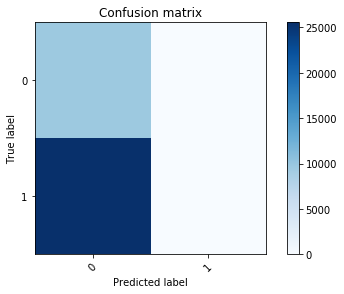

Plotting ROC Curve


C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


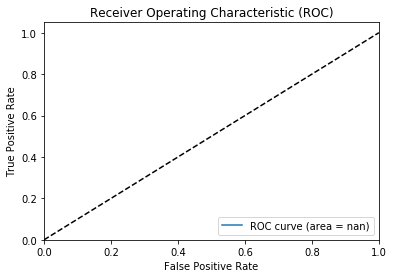

In [93]:
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(4):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(60, activation='relu'))    
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

In [1]:
df['Open'].unique

NameError: name 'df' is not defined

## 2) Activation - Sigmoid And Optimzer - Adam

0
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.24685, saving model to ./best_weights.hdf5
38817/38817 - 9s - loss: 0.3960 - val_loss: 0.2468
Epoch 2/100

Epoch 00002: val_loss improved from 0.24685 to 0.21531, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 0.2955 - val_loss: 0.2153
Epoch 3/100

Epoch 00003: val_loss improved from 0.21531 to 0.20880, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 0.3278 - val_loss: 0.2088
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.20880
38817/38817 - 6s - loss: 0.3363 - val_loss: 0.2345
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.20880
38817/38817 - 6s - loss: 0.3367 - val_loss: 0.2181
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.20880
38817/38817 - 6s - loss: 0.3732 - val_loss: 0.2198
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.20880
38817/38817 - 5s - loss: 0.3627 - val_loss: 0.2352
Epoch 8/100

Epoch 00008

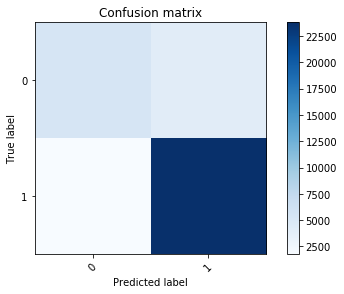

Plotting ROC Curve


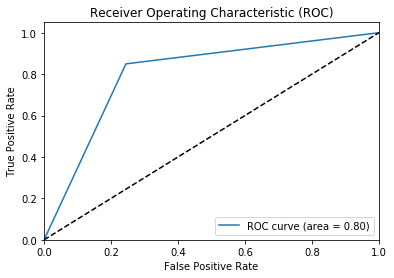

In [94]:
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(25, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

## Activation - Sigmoid and Optimizer - SGD

In [ ]:
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(64, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

0
Train on 38817 samples, validate on 35179 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.67561, saving model to ./best_weights.hdf5
38817/38817 - 10s - loss: 0.6947 - val_loss: 0.6756
Epoch 2/100

Epoch 00002: val_loss improved from 0.67561 to 0.67031, saving model to ./best_weights.hdf5
38817/38817 - 6s - loss: 0.6882 - val_loss: 0.6703
Epoch 3/100

Epoch 00003: val_loss improved from 0.67031 to 0.65986, saving model to ./best_weights.hdf5
38817/38817 - 5s - loss: 0.6844 - val_loss: 0.6599
Epoch 4/100

Epoch 00004: val_loss improved from 0.65986 to 0.65633, saving model to ./best_weights.hdf5
38817/38817 - 6s - loss: 0.6775 - val_loss: 0.6563
Epoch 5/100

Epoch 00005: val_loss improved from 0.65633 to 0.63020, saving model to ./best_weights.hdf5
38817/38817 - 6s - loss: 0.6646 - val_loss: 0.6302
Epoch 6/100

Epoch 00006: val_loss improved from 0.63020 to 0.58112, saving model to ./best_weights.hdf5
38817/38817 - 6s - loss: 0.6422 - val_loss: 0.5811
Epoch 7/100

Ep

Epoch 6/100

Epoch 00006: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5269 - val_loss: 0.3973
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.28106
38817/38817 - 5s - loss: 0.5112 - val_loss: 0.4373
Epoch 8/100

Epoch 00008: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5080 - val_loss: 0.3767
Epoch 9/100

Epoch 00009: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5077 - val_loss: 0.3465
Epoch 10/100

Epoch 00010: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5115 - val_loss: 0.3431
Epoch 11/100

Epoch 00011: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5108 - val_loss: 0.3414
Epoch 12/100

Epoch 00012: val_loss did not improve from 0.28106
38817/38817 - 5s - loss: 0.5119 - val_loss: 0.3358
Epoch 13/100

Epoch 00013: val_loss did not improve from 0.28106
38817/38817 - 6s - loss: 0.5188 - val_loss: 0.3272
Epoch 14/100

Epoch 00014: val_loss did not improve from 0.28106
38817/38817

## 3) Activation - Tanh and Optimizer - Adam

In [ ]:
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

## Activation - Tanh and Optimizer - SGD

In [ ]:
#path = '/dnn/'
#os.mkdir(path)

x,y = to_xy(dataset,'label')
x_test,y_test = to_xy(datatest,'label')

model = Sequential()

#Check pointer
checkpointer = ModelCheckpoint(filepath="./best_weights.hdf5", verbose=1, save_best_only=True)

for i in range(5):
    print(i)

    # Build network
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    #SAVE THE BEST MODEL 
    model.fit(x,y,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    
    
print('Training finished...Loading the best model')  
print()
#model.load_weights('dnn/best_weights.hdf5') # load weights from best model

#Measuring accuracy 
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)

y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


print(classification_report(y_true, pred))

y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

## Dropping LABEL 

In [92]:
#datatest.drop('label',axis=1,inplace=True)

## Nearest Neighbors

score_accuracy:  0.970436908382842
score_precision:  0.9705208308339474
score_recall:  0.970436908382842
score_f1:  0.9701467724863452
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      9625
           1       0.97      0.99      0.98     25554

    accuracy                           0.97     35179
   macro avg       0.97      0.95      0.96     35179
weighted avg       0.97      0.97      0.97     35179

[[ 8818   807]
 [  233 25321]]
Ploting confusion matrix


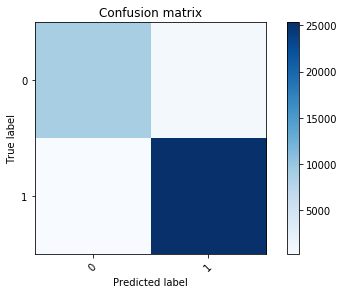

Plotting ROC Curve


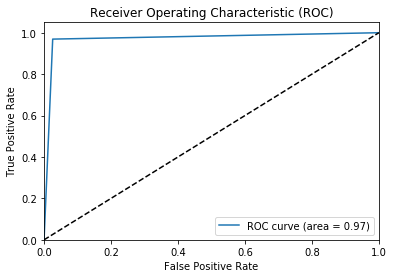

In [80]:
x,y = to_xy(dataset,'label')

knn = KNeighborsClassifier(n_neighbors=2)
y= dataset['label']
knn.fit(x, y)

knn_pred=knn.predict(datatest)

score_accuracy= metrics.accuracy_score(yLabel, knn_pred)
score_precision=metrics.precision_score(yLabel, knn_pred, average="weighted")
score_recall=metrics.recall_score(yLabel, knn_pred, average="weighted")
score_f1=metrics.f1_score(yLabel, knn_pred, average="weighted")

print("score_accuracy: " ,score_accuracy)
print("score_precision: " ,score_precision)
print("score_recall: " ,score_recall)
print("score_f1: " ,score_f1)

print(classification_report(yLabel,knn_pred))

#y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(yLabel, knn_pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(yLabel, knn_pred)

## Logistic Regression

C:\Users\yesha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


score_accuracy:  0.9185593678046562
score_precision:  0.9254295115578327
score_recall:  0.9185593678046562
score_f1:  0.9139057623016416
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      9625
           1       0.90      1.00      0.95     25554

    accuracy                           0.92     35179
   macro avg       0.95      0.85      0.89     35179
weighted avg       0.93      0.92      0.91     35179

[[ 6830  2795]
 [   70 25484]]
Ploting confusion matrix


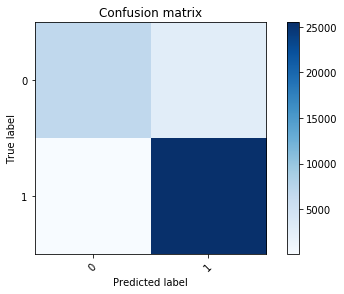

Plotting ROC Curve


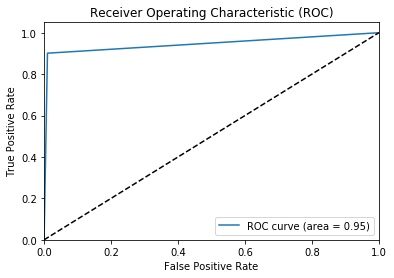

In [51]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x, y)

# predict the response for new observations
logR_pred = logreg.predict(datatest)

score_accuracy_lr= metrics.accuracy_score(yLabel, logR_pred)
score_precision_lr=metrics.precision_score(yLabel, logR_pred, average="weighted")
score_recall_lr=metrics.recall_score(yLabel, logR_pred, average="weighted")
score_f1_lr=metrics.f1_score(yLabel, logR_pred, average="weighted")

print("score_accuracy: " ,score_accuracy_lr)
print("score_precision: " ,score_precision_lr)
print("score_recall: " ,score_recall_lr)
print("score_f1: " ,score_f1_lr)

print(classification_report(yLabel,logR_pred))

#y_true = np.argmax(y_test,axis=1)
    
# Compute confusion matrix
cm = confusion_matrix(yLabel, logR_pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(yLabel, logR_pred)

## SVM - Support Vector Machine

score_accuracy:  0.9384007504477103
score_precision:  0.9426237629283127
score_recall:  0.9384007504477103
score_f1:  0.9358697392464034
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9625
           1       0.92      1.00      0.96     25554

    accuracy                           0.94     35179
   macro avg       0.96      0.89      0.92     35179
weighted avg       0.94      0.94      0.94     35179

Plotting ROC Curve


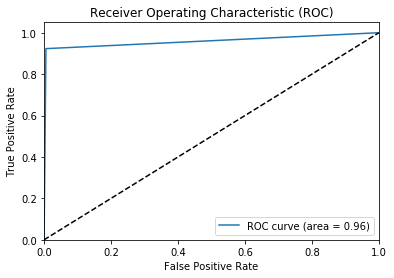

In [81]:
model = svm.SVC(gamma = 'auto') 
model.fit(x, y)

SVM_pred = model.predict(datatest)

score_accuracy_svm= metrics.accuracy_score(yLabel, SVM_pred)
score_precision_svm=metrics.precision_score(yLabel, SVM_pred, average="weighted")
score_recall_svm=metrics.recall_score(yLabel, SVM_pred, average="weighted")
score_f1_svm=metrics.f1_score(yLabel, SVM_pred, average="weighted")

print("score_accuracy: " ,score_accuracy_svm)
print("score_precision: " ,score_precision_svm)
print("score_recall: " ,score_recall_svm)
print("score_f1: " ,score_f1_svm)
print(classification_report(yLabel, SVM_pred))

print('Plotting ROC Curve')
plot_roc(y_true, SVM_pred)